In [1]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import OutputType
import pandas as pd
import datetime as datetime
from datetime import datetime, timedelta
from dateutil.parser import parse
from pulp import *
import numpy as np
from sklearn import linear_model
import os.path
from os import path
import seaborn as sns

In [ ]:
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)

In [41]:
client.player_box_scores(day=31, month=7, year=2020)

InvalidDate: Date with year set to 2020, month set to 7, and day set to 31 is invalid

In [2]:
all_tables = []
for m in range(1, 3):
    if m == 2:
        for d in range(1, 29):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    else:
        for d in range(1, 32):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            table  = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

In [3]:
full_df = all_tables[0]
for i in range(1, len(all_tables)):
    current_table = all_tables[i]
    full_df = full_df.append(current_table)
full_df.to_csv("./OutputCSVs/all_games.csv")

In [4]:
df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
df["team"] = df["team"].str.upper()
all_games = pd.read_csv("./OutputCSVs/all_games.csv")

team_def = []
team_pace = []
team_tov = []
opp_def = []
opp_pace = []
opp_tov = []
all_games_teams = all_games[["team", "opponent"]]

for i in range(len(all_games_teams)):
    game = all_games_teams.loc[i]
    team = game["team"]
    opponent = game["opponent"]
    team_def.append(df[df["team"] == team]["drtg"].iloc[0])
    team_pace.append(df[df["team"] == team]["pace"].iloc[0])
    team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
    opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
    opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
    opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
all_games["Team Defensive Rating"] = team_def
all_games["Team Pace"] = team_pace
all_games["Team Turnover %"] = team_tov
all_games["Opponent Defensive Rating"] = opp_def
all_games["Opponent Pace"] = opp_pace
all_games["Opponent Turnover %"] = opp_tov

all_games.to_csv("./OutputCSVs/all_games_new.csv")
df = pd.read_csv("./OutputCSVs/all_games_new.csv")
attempted_2s = df["attempted_field_goals"] - df["attempted_three_point_field_goals"]
made_2s = df["made_field_goals"] - df["made_three_point_field_goals"]
rebounds = df["offensive_rebounds"] + df["defensive_rebounds"]
at_home = df["location"] == "HOME"
df["attempted_two_point_field_goals"] = attempted_2s
df["made_two_point_field_goals"] = made_2s
df["total_rebounds"] = rebounds
df["at_home"] = at_home
df.to_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual = pd.read_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual =  all_games_actual.iloc[:, 3:].reset_index()

In [5]:
def get_stats(player, date, number_rows):
    converted_datetime = datetime.strptime(date, '%Y-%m-%d')
    player_rows = all_games_actual.loc[all_games_actual['name'] == player]
    #print(player_rows)
    selected_rows = []
    if (len(player_rows)) < number_rows:
        for i in range(len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
        return pd.DataFrame(selected_rows)
    index = 0
    for i in range(len(player_rows)):
        curr_date = player_rows.iloc[i]['Date']
        if datetime.strptime(curr_date, '%Y-%m-%d') >= converted_datetime:
            index = i - 1
            break
    if index != 0:
        if index + 1 - number_rows < 0:
            for i in range(index + 1):
                selected_rows.append(player_rows.iloc[i])
        else:
            for i in range(index + 1 - number_rows, index + 1):
                selected_rows.append(player_rows.iloc[i])
#     elif converted_datetime >= players_rows[len(player_rows) - 1]:
    else:
        for i in range(len(player_rows) - number_rows, len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
    return pd.DataFrame(selected_rows)

In [105]:
def get_points(row_data):
    if 'made_three_point_field_goals_y' in row_data.columns:
        three_pt_fgs = row_data['made_three_point_field_goals_y']
        two_pt_fgs = row_data['made_two_point_field_goals_y']
        made_fts = row_data['made_free_throws_y']
        total_rebounds = row_data['rebounds_y']
        assists = row_data['assists_y']
        blocks = row_data['blocks_y']
        steals = row_data['steals_y']
        turnovers = row_data['turnovers_y']
    else:
        three_pt_fgs = row_data['made_three_point_field_goals']
        two_pt_fgs = row_data['made_two_point_field_goals']
        made_fts = row_data['made_free_throws']
        total_rebounds = row_data['rebounds']
        assists = row_data['assists']
        blocks = row_data['blocks']
        steals = row_data['steals']
        turnovers = row_data['turnovers']
    FD_points = three_pt_fgs * 3 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.2 + assists * 1.5 + blocks * 3 + steals * 3 - turnovers
    FD_dollars = FD_points * 200
    return (FD_points, FD_dollars)

In [7]:
def weight_function(statistic, weight):
    s = 0
    if type(statistic) == np.ndarray:
        for i in range(len(statistic)):
            s += statistic[len(statistic) - i - 1] * (weight ** i)
    else:
        for i in range(len(statistic)):
            s += statistic.iloc[len(statistic) - i - 1,] * (weight ** i)
    return s

In [113]:
def time_weighted_average(rows, statistic, weight):
    if rows.empty:
        return 0
    stat = rows[statistic]
    this_num = 1 / weight_function(np.ones(len(stat)), weight)
    return this_num * weight_function(stat, weight)
player_box_scores = pd.read_csv('./OutputCSVs/all_games_updated.csv')

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']

In [9]:
def statline_predictor(player_box_scores, input_statistics, sample_size = 5, weight = .8):
    player_box_scores = player_box_scores[~player_box_scores.index.duplicated()]
    player_box_scores.reindex(range(len(player_box_scores)), axis = "index")
    predicted_statlines = pd.DataFrame(index = player_box_scores.index, columns = input_statistics).fillna(0).T
    index_len = len(player_box_scores.index)
    for box_index in player_box_scores.index:
        box_score = player_box_scores.loc[box_index]
        player_name = box_score["name"]
        game_date = str(box_score["Date"])[:10]
        last_n_rows = get_stats(player_name, game_date, sample_size)
        weighted_stats = [player_name, box_score["team"], game_date, box_score["location"], box_score["opponent"]]
        for stat in input_statistics[5:]:
            weighted_stats.append(round(time_weighted_average(last_n_rows, stat, weight), 2))
        predicted_statlines[box_index] = weighted_stats
    return predicted_statlines.T

In [11]:
predictions_samplesize5 = statline_predictor(all_games_actual, input_statistics, sample_size = 5)
predictions_samplesize5.to_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
predictions_samplesize10 = statline_predictor(all_games_actual, input_statistics, sample_size = 10)
predictions_samplesize10.to_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")

In [19]:
def rebound_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds_y"] + .2874 * weighted_stats["defensive_rebounds_y"]
    else:
        return 3.495 + .9489 * weighted_stats["offensive_rebounds"] + .2874 * weighted_stats["defensive_rebounds"]
def freethrow_predictor_5(weighted_stats):
    if "attempted_free_throws_y" in weighted_stats.index:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws_y"] + -.0373 * weighted_stats["attempted_field_goals_y"] -.3289 * (weighted_stats["location_y"] == "HOME")
    else:
        return 1.373 + .6217 * weighted_stats["attempted_free_throws"] + -.0373 * weighted_stats["attempted_field_goals"] -.3289 * (weighted_stats["location"] == "HOME")
def twopt_predictor_5(weighted_stats):
    if "attempted_field_goals_y" in weighted_stats.index:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals_y"] - .2542 * weighted_stats["attempted_field_goals_y"] + .071 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -5.395 + .6064 * weighted_stats["attempted_two_point_field_goals"] - .2542 * weighted_stats["attempted_field_goals"] + .071 * weighted_stats["Opponent Defensive Rating"])
def threept_predictor_5(weighted_stats):
    if "attempted_three_point_field_goals_y" in weighted_stats.index:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals_y"]
    else:
        return .766 + .214 * weighted_stats["attempted_three_point_field_goals"]
def assist_predictor_5(weighted_stats):
    if "assists_y" in weighted_stats.index:
        return 2.06 + .532 * weighted_stats["assists_y"] - .064 * weighted_stats["blocks_y"]
    else:
        return 2.06 + .532 * weighted_stats["assists"] - .064 * weighted_stats["blocks"]
def block_predictor_5(weighted_stats):
    if "offensive_rebounds_y" in weighted_stats.index:
        return .329 + .182 * weighted_stats["offensive_rebounds_y"] - .038 * weighted_stats["defensive_rebounds_y"] + .424 * weighted_stats["blocks_y"]
    else:
        return .329 + .182 * weighted_stats["offensive_rebounds"] - .038 * weighted_stats["defensive_rebounds"] + .424 * weighted_stats["blocks"]
def steal_predictor_5(weighted_stats):
    if "steals_y" in weighted_stats.index:
        return max(0, -.936 + .339 * weighted_stats["steals_y"] + .129 * weighted_stats["Opponent Turnover %"])
    else:
        return max(0, -.936 + .339 * weighted_stats["steals"] + .129 * weighted_stats["Opponent Turnover %"])
def turnover_predictor_5(weighted_stats):
    if "turnovers_y" in weighted_stats.index:
        return max(0, -2.589 + .18 * weighted_stats["turnovers_y"] + .121 * weighted_stats["assists_y"] + .032 * weighted_stats["Opponent Defensive Rating"])
    else:
        return max(0, -2.589 + .18 * weighted_stats["turnovers"] + .121 * weighted_stats["assists"] + .032 * weighted_stats["Opponent Defensive Rating"])
def minutes_predictor(weighted_stats):
    if "seconds_played_y" in weighted_stats.index:
        return np.mean(weighted_stats["seconds_played_y"])/60
    else:
        return np.mean(weighted_stats["seconds_played"])/60
def recent_average(weighted_stats):
    if "made_three_point_field_goals_y" in weighted_stats.index:
        return 3*np.mean(weighted_stats["made_three_point_field_goals_y"]) + 2*np.mean(weighted_stats["made_two_point_field_goals_y"]) + np.mean(weighted_stats["made_free_throws_y"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds_y"]) + np.mean(weighted_stats["defensive_rebounds_y"])) + 1.5*np.mean(weighted_stats["assists_y"]) + 3*np.mean(weighted_stats["blocks_y"]) + 3*np.mean(weighted_stats["steals_y"]) - np.mean(weighted_stats["turnovers_y"])
    else:
        return 3*np.mean(weighted_stats["made_three_point_field_goals"]) + 2*np.mean(weighted_stats["made_two_point_field_goals"]) + np.mean(weighted_stats["made_free_throws"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds"]) + np.mean(weighted_stats["defensive_rebounds"])) + 1.5*np.mean(weighted_stats["assists"]) + 3*np.mean(weighted_stats["blocks"]) + 3*np.mean(weighted_stats["steals"]) - np.mean(weighted_stats["turnovers"])

In [13]:
all_games_predicted_5 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_5_games.csv")
all_games_predicted_5 = all_games_predicted_5.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_5 = all_games_actual.merge(all_games_predicted_5, left_on="index", right_on="indexr")
all_games_predicted_10 = pd.read_csv("./OutputCSVs/predicted_statlines_trailing_10_games.csv")
all_games_predicted_10 = all_games_predicted_10.rename(columns={"Unnamed: 0": "indexr"})
all_games_merged_10 = all_games_actual.merge(all_games_predicted_10, left_on="index", right_on="indexr")
all_games_merged_5.to_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")
all_games_merged_10.to_csv("./OutputCSVs/true_and_predicted_statlines_10.csv")

In [14]:
weighted_preds = pd.read_csv("./OutputCSVs/true_and_predicted_statlines_5.csv")

In [119]:
from sklearn.linear_model import RidgeCV

output_statistics = ["name", "team", "date", "location", "opponent", "minutes", "made_two_point_field_goals", "made_three_point_field_goals", "made_free_throws", "rebounds", "assists", "blocks", "steals", "turnovers", "recent_average", "fantasy_points"]

def statline_output(player_box_scores, input_statistics):
    weighted_lines_7_9 = statline_predictor(player_box_scores, input_statistics, 7, .9)
    weighted_lines_8_8 = statline_predictor(player_box_scores, input_statistics, 8, .8)
    weighted_lines_8_85 = statline_predictor(player_box_scores, input_statistics, 8, .85)
    weighted_lines_8_9 = statline_predictor(player_box_scores, input_statistics, 8, .9)
    weighted_lines_to_keep_7_9 = weighted_lines_7_9[weighted_lines_7_9.seconds_played > 1000]
    weighted_lines_to_keep_8_8 = weighted_lines_8_8[weighted_lines_8_8.seconds_played > 1000]
    weighted_lines_to_keep_8_85 = weighted_lines_8_85[weighted_lines_8_85.seconds_played > 1000]
    weighted_lines_to_keep_8_9 = weighted_lines_8_9[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep = player_box_scores[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_lines_to_keep_7_9['name_date'] = weighted_lines_to_keep_7_9["name"] + weighted_lines_to_keep_7_9["date"].astype(str)
    weighted_lines_to_keep_8_8['name_date'] = weighted_lines_to_keep_8_8["name"] + weighted_lines_to_keep_8_8["date"].astype(str)
    weighted_lines_to_keep_8_85['name_date'] = weighted_lines_to_keep_8_85["name"] + weighted_lines_to_keep_8_85["date"].astype(str)
    weighted_lines_to_keep_8_9['name_date'] = weighted_lines_to_keep_8_9["name"] + weighted_lines_to_keep_8_9["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged_7_9 = weighted_lines_to_keep_7_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_7_9["rebounds_y"] = df_merged_7_9["offensive_rebounds_y"] + df_merged_7_9["defensive_rebounds_y"]
    df_merged_7_9["location_x"] = df_merged_7_9["location_x"] == "HOME"
    df_merged_7_9["location_y"] = df_merged_7_9["location_y"] == "HOME"
    df_merged_8_8 = weighted_lines_to_keep_8_8.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_8["rebounds_y"] = df_merged_8_8["offensive_rebounds_y"] + df_merged_8_8["defensive_rebounds_y"]
    df_merged_8_8["location_x"] = df_merged_8_8["location_x"] == "HOME"
    df_merged_8_8["location_y"] = df_merged_8_8["location_y"] == "HOME"
    df_merged_8_85 = weighted_lines_to_keep_8_85.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_85["rebounds_y"] = df_merged_8_85["offensive_rebounds_y"] + df_merged_8_85["defensive_rebounds_y"]
    df_merged_8_85["location_x"] = df_merged_8_85["location_x"] == "HOME"
    df_merged_8_85["location_y"] = df_merged_8_85["location_y"] == "HOME"
    df_merged_8_9 = weighted_lines_to_keep_8_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_9["rebounds_y"] = df_merged_8_9["offensive_rebounds_y"] + df_merged_8_9["defensive_rebounds_y"]
    df_merged_8_9["location_x"] = df_merged_8_9["location_x"] == "HOME"
    df_merged_8_9["location_y"] = df_merged_8_9["location_y"] == "HOME"
    predictors_7_9 = df_merged_7_9.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_8 = df_merged_8_8.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_85 = df_merged_8_85.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_9 = df_merged_8_9.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    df_merged_7_9["fantasy_points"] = [float(get_points(df_merged_7_9[df_merged_7_9["name_date"] == player_name])[0]) for player_name in df_merged_7_9["name_date"]]
    df_merged_8_8["fantasy_points"] = [float(get_points(df_merged_8_8[df_merged_8_8["name_date"] == player_name])[0]) for player_name in df_merged_8_8["name_date"]]
    df_merged_8_85["fantasy_points"] = [float(get_points(df_merged_8_85[df_merged_8_85["name_date"] == player_name])[0]) for player_name in df_merged_8_85["name_date"]]
    df_merged_8_9["fantasy_points"] = [float(get_points(df_merged_8_9[df_merged_8_9["name_date"] == player_name])[0]) for player_name in df_merged_8_9["name_date"]]
    fantasy_points_7_9 = df_merged_7_9.iloc[:,58]
    fantasy_points_8_8 = df_merged_8_8.iloc[:,58]
    fantasy_points_8_85 = df_merged_8_85.iloc[:,58]
    fantasy_points_8_9 = df_merged_8_9.iloc[:,58]
    freethrows = df_merged_7_9.iloc[:,38]
    twopoints = df_merged_8_8.iloc[:,56]
    threepoints = df_merged_8_85.iloc[:,36]
    blocks = df_merged_8_85.iloc[:,44]
    assists = df_merged_8_9.iloc[:,42]
    rebounds = df_merged_8_9.iloc[:,57]
    turnovers = df_merged_8_9.iloc[:,45]
    seconds = df_merged_8_9.iloc[:,33]
    steals = df_merged_8_9.iloc[:,43]
    fantasy_model_7_9 = RidgeCV().fit(predictors_7_9, fantasy_points_7_9)
    fantasy_model_8_8 = RidgeCV().fit(predictors_8_8, fantasy_points_8_8)
    fantasy_model_8_85 = RidgeCV().fit(predictors_8_85, fantasy_points_8_85)
    fantasy_model_8_9 = RidgeCV().fit(predictors_8_9, fantasy_points_8_9)
    freethrow_model = RidgeCV().fit(predictors_7_9, freethrows)
    twopoint_model = RidgeCV().fit(predictors_8_8, twopoints)
    threepoint_model = RidgeCV().fit(predictors_8_85, threepoints)
    block_model = RidgeCV().fit(predictors_8_85, blocks)
    assist_model = RidgeCV().fit(predictors_8_9, assists)
    rebound_model = RidgeCV().fit(predictors_8_9, rebounds)
    turnover_model = RidgeCV().fit(predictors_8_9, turnovers)
    second_model = RidgeCV().fit(predictors_8_9, seconds)
    steal_model = RidgeCV().fit(predictors_8_9, steals)

    
    output_statlines = pd.DataFrame(index = weighted_lines_8_9.index, columns = output_statistics).fillna(0)
    output_statlines["name"] = weighted_lines_8_9["name"]
    output_statlines["team"] = weighted_lines_8_9["team"]
    output_statlines["date"] = weighted_lines_8_9["date"]
    output_statlines["location"] = weighted_lines_8_9["location"]
    output_statlines["opponent"] = weighted_lines_8_9["opponent"]
    weighted_lines_7_9["location"] = weighted_lines_7_9["location"] == "HOME"
    weighted_lines_8_8["location"] = weighted_lines_8_8["location"] == "HOME"
    weighted_lines_8_85["location"] = weighted_lines_8_85["location"] == "HOME"
    weighted_lines_8_9["location"] = weighted_lines_8_9["location"] == "HOME"
    weighted_lines_7_9 = weighted_lines_7_9.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_8 = weighted_lines_8_8.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_85 = weighted_lines_8_85.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_9 = weighted_lines_8_9.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]

    output_statlines["minutes"] = second_model.predict(weighted_lines_8_9) / 60
    output_statlines["made_two_point_field_goals"] = twopoint_model.predict(weighted_lines_8_8)
    output_statlines["made_three_point_field_goals"] = threepoint_model.predict(weighted_lines_8_85) 
    output_statlines["made_free_throws"] = freethrow_model.predict(weighted_lines_7_9)
    output_statlines["rebounds"] = rebound_model.predict(weighted_lines_8_9)
    output_statlines["assists"] = assist_model.predict(weighted_lines_8_9)
    output_statlines["blocks"] = block_model.predict(weighted_lines_8_85)
    output_statlines["steals"] = steal_model.predict(weighted_lines_8_9) 
    output_statlines["turnovers"] = turnover_model.predict(weighted_lines_8_9)
    output_statlines["fantasy_points_7_9"] = fantasy_model_7_9.predict(weighted_lines_7_9)
    output_statlines["fantasy_points_8_8"] = fantasy_model_8_8.predict(weighted_lines_8_8)
    output_statlines["fantasy_points_8_85"] = fantasy_model_8_85.predict(weighted_lines_8_85)
    output_statlines["fantasy_points_8_9"] = fantasy_model_8_9.predict(weighted_lines_8_9)
    for box_index in output_statlines.index:
        pred_minutes = max(0, output_statlines.loc[box_index, "minutes"])
        if pred_minutes <= 19:
            output_statlines.loc[box_index, "made_two_point_field_goals"] = output_statlines.loc[box_index, "made_two_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_three_point_field_goals"] = output_statlines.loc[box_index, "made_three_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_free_throws"] = output_statlines.loc[box_index, "made_free_throws"] * pred_minutes/19
            output_statlines.loc[box_index, "rebounds"] = output_statlines.loc[box_index, "rebounds"] * pred_minutes/19
            output_statlines.loc[box_index, "assists"] = output_statlines.loc[box_index, "assists"] * pred_minutes/19
            output_statlines.loc[box_index, "blocks"] = output_statlines.loc[box_index, "blocks"] * pred_minutes/19
            output_statlines.loc[box_index, "steals"] = output_statlines.loc[box_index, "steals"] * pred_minutes/19
            output_statlines.loc[box_index, "turnovers"] = output_statlines.loc[box_index, "turnovers"] * pred_minutes/19
        output_statlines.loc[box_index, "minutes"] = pred_minutes
        output_statlines.loc[box_index, "made_two_point_field_goals"] = max(0, output_statlines.loc[box_index, "made_two_point_field_goals"])
        output_statlines.loc[box_index, "made_three_point_field_goals"] = max(0, output_statlines.loc[box_index, "made_three_point_field_goals"])
        output_statlines.loc[box_index, "made_free_throws"] = max(0, output_statlines.loc[box_index, "made_free_throws"])
        output_statlines.loc[box_index, "rebounds"] = max(0, output_statlines.loc[box_index, "rebounds"])
        output_statlines.loc[box_index, "assists"] = max(0, output_statlines.loc[box_index, "assists"])
        output_statlines.loc[box_index, "blocks"] = max(0, output_statlines.loc[box_index, "blocks"])
        output_statlines.loc[box_index, "steals"] = max(0, output_statlines.loc[box_index, "steals"])
        output_statlines.loc[box_index, "turnovers"] = max(0, output_statlines.loc[box_index, "turnovers"])
        output_statlines.loc[box_index, "recent_average"] = np.mean([recent_average(weighted_lines_8_85.loc[box_index]), recent_average(weighted_lines_8_9.loc[box_index]), recent_average(weighted_lines_8_8.loc[box_index]), recent_average(weighted_lines_7_9.loc[box_index])])
    return output_statlines

In [22]:
jan_feb_data = pd.read_csv('./OutputCSVs/predicted_statlines_jan_feb_2020.csv')
FD_points_array = []
FD_dollars_array = []
sum_points = 0
counter = 0
for index, row in jan_feb_data.iterrows():
    tuple_values = get_points(row)
    FD_points_array.append(tuple_values[0])
    FD_dollars_array.append(tuple_values[1])
    sum_points += tuple_values[0]
    counter += 1
jan_feb_data['FanDuel_Points'] = FD_points_array
jan_feb_data['FanDuel_Dollars'] = FD_dollars_array
jan_feb_data.to_csv("./OutputCSVs/Jan_Feb_statline_with_FanDuel_dollars.csv")

In [11]:
def generate_optimal_lineup(players, positions, values, costs, budget):
    num_variables = len(players)
    
    lp = LpProblem("My LP Problem", pulp.LpMaximize)
    
    d = {}
    for i in range(0, num_variables):
        d[players[i]] = LpVariable(players[i], cat="Binary")
    
    objective = sum(np.array(values) * np.array(list(d.values())))
    lp += objective
    
    pg_constraint = 0
    sg_constraint = 0
    sf_constraint = 0
    pf_constraint = 0
    c_constraint = 0
    for i in range(0, len(positions)):
        if positions[i] == "PG":
            pg_constraint += d[players[i]]
        elif positions[i] == "SG":
            sg_constraint += d[players[i]]
        elif positions[i] == "SF":
            sf_constraint += d[players[i]]
        elif positions[i] == "PF":
            pf_constraint += d[players[i]]
        else:
            c_constraint += d[players[i]]
    lp += pg_constraint == 2
    lp += sg_constraint == 2
    lp += sf_constraint == 2
    lp += pf_constraint == 2
    lp += c_constraint == 1
    
    cost = sum(np.array(costs) * np.array(list(d.values())))
    lp += cost <= budget
    
    lp.solve()
    
    lineup = [variable.name for variable in lp.variables() if variable.varValue == 1]
    print(lineup)
    #for variable in lp.variables():
    #    print ("{} = {}".format(variable.name, variable.varValue))
    #print(pulp.value(lp.objective))

In [12]:
def box_scores_for_range_of_days(start_date, end_date):
    all_tables = []
    start_month = start_date.month
    end_month = end_date.month
    for m in range(start_month, end_month + 1):
        if m == start_month:
            start_day = start_date.day
        else:
            start_day = 1
        if m == end_month:
            end_day = end_date.day
        else:
            if m == 2:
                end_day = 29
            elif m in [9, 4, 6, 11]:
                end_day = 30
            else:
                end_day = 31
        
        for d in range(start_day, end_day + 1):
            file_name = "./AllCSVs/{0}_{1}_2020_box_scores.csv".format(m, d)
            if not path.exists(file_name):
                continue
            if pd.read_csv(file_name).empty:
                client.player_box_scores(day=d, month=m, year=2020, output_type=OutputType.CSV, output_file_path=file_name)
            table = pd.read_csv(file_name)
            date = datetime(2020, m, d)
            dates = [date] * len(table)
            table["Date"] = dates
            all_tables.append(table)

    full_df = all_tables[0]
    for i in range(1, len(all_tables)):
        current_table = all_tables[i]
        full_df = full_df.append(current_table)
    
    full_df.index = range(full_df.shape[0])
    df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
    df["team"] = df["team"].str.upper()

    team_def = []
    team_pace = []
    team_tov = []
    opp_def = []
    opp_pace = []
    opp_tov = []
    all_games_teams = full_df[["team", "opponent"]]

    for i in range(len(all_games_teams)):
        game = all_games_teams.loc[i]
        team = game["team"].upper()
        opponent = game["opponent"].upper()
        team_def.append(df[df["team"] == team]["drtg"].iloc[0])
        team_pace.append(df[df["team"] == team]["pace"].iloc[0])
        team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
        opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
        opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
        opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
    full_df["Team Defensive Rating"] = team_def
    full_df["Team Pace"] = team_pace
    full_df["Team Turnover %"] = team_tov
    full_df["Opponent Defensive Rating"] = opp_def
    full_df["Opponent Pace"] = opp_pace
    full_df["Opponent Turnover %"] = opp_tov
    return full_df

In [13]:
def make_predictions(start_date, end_date, output = True):
    input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']
    full_df = box_scores_for_range_of_days(start_date, end_date)
    predicted_statlines = statline_output(full_df, input_statistics)
    if output:
        output_filename = './AllCSVs/' + str(start_date.month) + '_' + str(start_date.day) + '_' + str(end_date.month) + '_' + str(end_date.day) + '_2020_predicted_box_scores.csv'
        predicted_statlines.to_csv(output_filename)
    return predicted_statlines

In [14]:
import pytz

def predict_next_day(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and game['start_time'].month == game_date.month]
    team_objs_on_date = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    teams_on_date = [t.name.replace("_", " ") for t in team_objs_on_date]
    predictions_for_date = make_predictions(start_date, game_date, output = False)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(teams_on_date)]
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = mstr + "-" + dstr
    statlines_on_date = players_on_date[players_on_date.date.str.contains(tstr)]
    statlines_on_date.index = range(statlines_on_date.shape[0])
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + '_from_' + str(start_date.month) + '_' + str(start_date.day) + '_2020.csv'
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
#predict_next_day(datetime(2020, 2, 1), datetime(2020, 2, 12))

In [15]:
def append_actual_results(start_date, game_date):
    predicted_results = predict_next_day(start_date, game_date)
    actual_results = box_scores_for_range_of_days(game_date, game_date)
    actual_results["made_two_point_field_goals"] = actual_results["made_field_goals"] - actual_results["made_three_point_field_goals"]
    actual_results["rebounds"] = actual_results["offensive_rebounds"] + actual_results["defensive_rebounds"]
    pred_outputs = [float(get_points(predicted_results[predicted_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    actual_outputs = [float(get_points(actual_results[actual_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    predicted_results["predicted_points"] = pred_outputs
    predicted_results["actual_points"] = actual_outputs
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_box_scores_predicted_with_actual.csv'
    predicted_results.to_csv(output_filename)
    return predicted_results

#append_actual_results(datetime(2020, 2, 1), datetime(2020, 2, 12))

In [16]:
def alternate_contests(start_date, game_date, search_datetime, inclusive):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    times_on_date = np.unique([game['start_time'] - timedelta(hours = 4) for game in schedule_on_date])
    print(times_on_date)
    if not inclusive:
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime]
    else:
        times_after_search = [t for t in times_on_date if 60 * t.hour + t.minute >= 60 * search_datetime.hour + search_datetime.minute]
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    predictions_for_date = predict_next_day(start_date, game_date)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(game_team_strings)]
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_2020_alternate_' + str(search_datetime.hour) + "_" + str(search_datetime.minute) + '.csv'
    players_on_date.to_csv(output_filename)
    return players_on_date
#alternate_contests(datetime(2020, 1, 1), datetime(2020, 1, 13), datetime(2020, 1, 13, 21, 30), True)

In [17]:
def matchup_lookup(matchups, team):
    matchup = [m for m in matchups if team in m][0]
    if team == matchup[0]:
        return matchup[1]
    else:
        return matchup[0]

def predict_unplayed_games(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    available_box_scores = box_scores_for_range_of_days(start_date, game_date)
    game_teams = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    matchups = [[str(game["home_team"])[5:].replace("_", " "), str(game["away_team"])[5:].replace("_", " ")] for game in schedule_on_date]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    relevant_lines = available_box_scores[available_box_scores.team.isin(game_team_strings)]
    relevant_players = relevant_lines.drop_duplicates(subset = ["name"])
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = str(game_date.year) + "-" + mstr + "-" + dstr
    relevant_players.Date = [tstr for _ in range(len(relevant_players))]
    relevant_players.location = ["AWAY" for _ in range(len(relevant_players))]
    relevant_players.opponent = [matchup_lookup(matchups, t) for t in relevant_players.team]
    augmented_box_scores = available_box_scores.append(relevant_players)
    augmented_box_scores.index = range(augmented_box_scores.shape[0])
    print(len(augmented_box_scores.columns), augmented_box_scores.columns)
    predicted_statlines = statline_output(augmented_box_scores, input_statistics)
    statlines_on_date = predicted_statlines[predicted_statlines.date.str.contains(tstr)]
    statlines_on_date['projected_points'] = [float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]) for player_name in statlines_on_date.name]
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + "_2020_unplayed.csv"
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
    
#july_30_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 30))
#july_30_predictions

In [89]:
#july_30_predictions = predict_unplayed_games(datetime(2020, 2, 20), datetime(2020, 7, 30))
len(july_30_predictions)

61

In [ ]:
def optimal_lineup_games(input_games, ):

In [37]:
from random import sample

for sample_size in range(6, 11):
    dates = sample(range(30), 5)
    errors = []
    for date in dates:
        game_date = datetime(2020, 2, date)
        print(game_date)
        results = append_actual_results(datetime(2020, 1, 2), game_date, sample_size)
        errors.append(np.mean((results.actual_points - results.predicted_points)**2))

        print(errors)

2020-02-11 00:00:00
2020-02-17 00:00:00
2020-02-02 00:00:00
2020-02-24 00:00:00
2020-02-04 00:00:00
[148.82838502050967, nan, 139.60488782064257, 142.8418045969123, 146.57561312068572]
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-10 00:00:00
[116.62257633648109, 137.511663253122, 141.54689884144622, 112.3495570579943, 115.21090394674252]
2020-02-19 00:00:00
2020-02-09 00:00:00
2020-02-16 00:00:00
2020-02-02 00:00:00
2020-02-23 00:00:00
[nan, 158.11006119379758, nan, 138.41111557349737, 151.29273243164425]
2020-02-24 00:00:00


KeyboardInterrupt: 

In [87]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %"]
def regression_by_sample(start_date, end_date, sample_size, weight):
    full_df = box_scores_for_range_of_days(start_date, end_date)
    weighted_statlines = statline_predictor(full_df, input_statistics, sample_size, weight)
    weighted_statlines_to_keep = weighted_statlines[weighted_statlines.seconds_played > 1000]
    df_to_keep = full_df[weighted_statlines.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_statlines_to_keep['name_date'] = weighted_statlines_to_keep["name"] + weighted_statlines_to_keep["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged = weighted_statlines_to_keep.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged["rebounds_y"] = df_merged["offensive_rebounds_y"] + df_merged["defensive_rebounds_y"]
    df_merged["location_x"] = df_merged["location_x"] == "HOME"
    df_merged["location_y"] = df_merged["location_y"] == "HOME"
    print(df_merged.columns)
    df_merged["fantasy_points"] = [float(get_points(df_merged[df_merged["name_date"] == player_name])[0]) for player_name in df_merged["name_date"]]
    df_merged = df_merged[df_merged.Date.astype(str).str.contains("2020-02")]
    predictors = df_merged.iloc[:,[3, 51, 52, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]]
    print(df_merged.columns[[3, 51, 52, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]])
    print(len(df_merged.columns), df_merged.columns)
    for desired_output in [54]:
        y = df_merged.iloc[:,desired_output]
        pred_train, pred_test, y_train, y_test = train_test_split(predictors, y, test_size=0.2, random_state=758)
        pred_train1, pred_test1, y_train1, y_test1 = train_test_split(predictors, y, test_size=0.2, random_state=3)
        pred_train2, pred_test2, y_train2, y_test2 = train_test_split(predictors, y, test_size=0.2, random_state=2690)
        pred_train3, pred_test3, y_train3, y_test3 = train_test_split(predictors, y, test_size=0.2, random_state=467)
        pred_train4, pred_test4, y_train4, y_test4 = train_test_split(predictors, y, test_size=0.2, random_state=9999)
        pred_train5, pred_test5, y_train5, y_test5 = train_test_split(predictors, y, test_size=0.2, random_state=34715)
        pred_train6, pred_test6, y_train6, y_test6 = train_test_split(predictors, y, test_size=0.2, random_state=88)
        ridge_model = RidgeCV().fit(pred_train, y_train)
        linear_model = LinearRegression().fit(pred_train, y_train)
        ridge_model1 = RidgeCV().fit(pred_train1, y_train1)
        linear_model1 = LinearRegression().fit(pred_train1, y_train1)
        ridge_model2 = RidgeCV().fit(pred_train2, y_train2)
        linear_model2 = LinearRegression().fit(pred_train2, y_train2)
        ridge_model3 = RidgeCV().fit(pred_train3, y_train3)
        linear_model3 = LinearRegression().fit(pred_train3, y_train3)
        ridge_model4 = RidgeCV().fit(pred_train4, y_train4)
        linear_model4 = LinearRegression().fit(pred_train4, y_train4)
        ridge_model5 = RidgeCV().fit(pred_train5, y_train5)
        linear_model5 = LinearRegression().fit(pred_train5, y_train5)
        ridge_model6 = RidgeCV().fit(pred_train6, y_train6)
        linear_model6 = LinearRegression().fit(pred_train6, y_train6)
        print(df_merged.columns[desired_output])
        print(ridge_model.score(pred_test, y_test))
        print(linear_model.score(pred_test, y_test))
        print(ridge_model1.score(pred_test1, y_test1))
        print(linear_model1.score(pred_test1, y_test1))
        print(ridge_model2.score(pred_test2, y_test2))
        print(linear_model2.score(pred_test2, y_test2))
        print(ridge_model3.score(pred_test3, y_test3))
        print(linear_model3.score(pred_test3, y_test3))
        print(ridge_model4.score(pred_test4, y_test4))
        print(linear_model4.score(pred_test4, y_test4))
        print(ridge_model5.score(pred_test5, y_test5))
        print(linear_model5.score(pred_test5, y_test5))
        print(ridge_model6.score(pred_test6, y_test6))
        print(linear_model6.score(pred_test6, y_test6))
    #return df_merged
for i, j in [(7, .9), (8, .8), (8, .85), (8, .9)]:
        regression_by_sample(datetime(2020, 1, 2), datetime(2020, 2, 29), i, j)

KeyboardInterrupt: 

In [120]:
#feb_12_pred_actual = append_actual_results(datetime(2020, 1, 17), datetime(2020, 2, 12))
#feb_12_predictions = predict_next_day(datetime(2020, 1, 17), datetime(2020, 2, 12))
#print("Feb. 12 done")
# jan_24_pred_actual = append_actual_results(datetime(2020, 1, 1), datetime(2020, 1, 24))
# jan_24_predictions = predict_next_day(datetime(2020, 1, 1), datetime(2020, 1, 24))
# print("Jan. 24 done")
#july_30_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 30))
# print("July 30 done")
july_31_predictions = predict_unplayed_games(datetime(2020, 2, 1), datetime(2020, 7, 31))
# print("July 31 done")
# late_jan_box_scores = box_scores_for_range_of_days(datetime(2020, 1, 24), datetime(2020, 1, 31))
#feb_12_pred_actual
july_31_predictions

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


28 Index(['slug', 'name', 'team', 'location', 'opponent', 'outcome',
       'seconds_played', 'made_field_goals', 'attempted_field_goals',
       'made_three_point_field_goals', 'attempted_three_point_field_goals',
       'made_free_throws', 'attempted_free_throws', 'offensive_rebounds',
       'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers',
       'personal_fouls', 'game_score', 'Date', 'Team Defensive Rating',
       'Team Pace', 'Team Turnover %', 'Opponent Defensive Rating',
       'Opponent Pace', 'Opponent Turnover %'],
      dtype='object')


c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,...,blocks,steals,turnovers,recent_average,fantasy_points,fantasy_points_7_9,fantasy_points_8_8,fantasy_points_8_85,fantasy_points_8_9,projected_points
4948,Damian Lillard,PORTLAND TRAIL BLAZERS,2020-07-31,AWAY,MEMPHIS GRIZZLIES,38.400584,5.331912,5.769407,4.128692,4.506479,...,0.192538,0.909446,3.074749,47.77550,0,44.644313,43.531155,44.524180,45.595094,47.091535
4949,Bradley Beal,WASHINGTON WIZARDS,2020-07-31,AWAY,PHOENIX SUNS,36.370230,7.283446,3.166661,6.916680,4.304422,...,1.081533,1.412037,3.016972,52.80550,0,47.315146,47.323838,47.033190,46.812451,47.510222
4950,Dorian Finney-Smith,DALLAS MAVERICKS,2020-07-31,AWAY,HOUSTON ROCKETS,24.797725,1.454046,1.741951,1.623021,5.006104,...,0.696908,1.047869,0.751180,18.96500,0,23.016049,23.431004,23.362554,23.262685,23.317294
4951,Jalen Brunson,DALLAS MAVERICKS,2020-07-31,AWAY,HOUSTON ROCKETS,22.129790,2.261946,1.184611,1.163481,2.315406,...,0.000000,0.601942,1.599994,14.20200,0,17.419845,16.116182,16.808491,17.672098,17.932849
4952,Jaylen Brown,BOSTON CELTICS,2020-07-31,AWAY,MILWAUKEE BUCKS,29.619632,4.511243,0.760807,2.742886,4.905041,...,0.729690,0.816149,1.199395,31.98200,0,27.388862,27.307474,27.535249,27.195289,26.392481
4953,DeMar DeRozan,SAN ANTONIO SPURS,2020-07-31,AWAY,SACRAMENTO KINGS,26.488126,8.235925,0.647890,4.521179,6.175916,...,0.000000,0.819772,2.256601,37.13175,0,36.750472,38.565299,37.250748,36.429187,38.405083
4954,Hassan Whiteside,PORTLAND TRAIL BLAZERS,2020-07-31,AWAY,MEMPHIS GRIZZLIES,32.776925,8.055843,0.562412,3.180800,18.255628,...,2.865498,0.687712,1.993290,46.83050,0,53.111218,53.265271,53.567163,53.822353,53.951406
4955,Maxi Kleber,DALLAS MAVERICKS,2020-07-31,AWAY,HOUSTON ROCKETS,28.072132,2.489134,2.384567,1.546015,6.063070,...,1.522658,1.053583,0.635694,24.17100,0,29.416509,30.253197,30.586874,30.638620,30.710900
4956,Nikola Vučević,ORLANDO MAGIC,2020-07-31,AWAY,BROOKLYN NETS,37.315085,7.180413,1.273245,1.414147,10.401596,...,0.282748,1.033158,1.981179,47.40075,0,39.511593,39.534732,40.080161,40.554475,39.783452
4957,Jayson Tatum,BOSTON CELTICS,2020-07-31,AWAY,MILWAUKEE BUCKS,33.232309,5.695602,3.394601,7.712968,7.817784,...,1.296047,0.723002,2.011848,49.03075,0,45.183731,45.848200,45.612398,45.509133,46.932603


(0.0716548140377653, 0.2048386770964351)

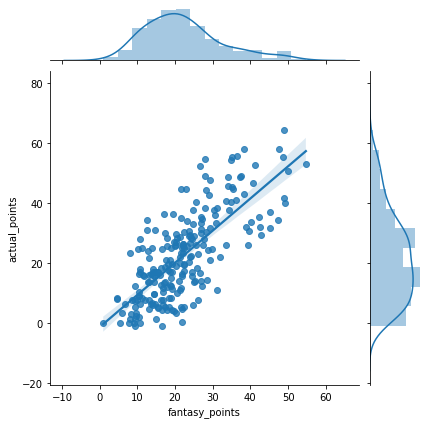

In [107]:
from sklearn.metrics import r2_score

#july_30_predictions.groupby(["team"]).sum()
#july_30_predictions[july_30_predictions["team"] == "LOS ANGELES CLIPPERS"]
#sns.distplot(july_30_predictions.projected_points)
#sns.distplot(july_30_predictions.recent_average)
#sns.jointplot(data = feb_12_pred_actual, x = "fantasy_points", y = "actual_points", kind = 'reg')
#jan_24_pred_actual["blended_prediction"] = .7*jan_24_pred_actual["recent_average"] + .3*jan_24_pred_actual["predicted_points"]
#feb_12_pred_actual_sig = feb_12_pred_actual[feb_12_pred_actual["minutes"] <= 19]

r2_score(feb_12_pred_actual.fantasy_points, feb_12_pred_actual.actual_points), r2_score(feb_12_pred_actual.recent_average, feb_12_pred_actual.actual_points)
#np.mean(jan_24_pred_actual["recent_average"]), np.mean(jan_24_pred_actual["predicted_points"]), np.mean(jan_24_pred_actual["actual_points"])
#r2_score(july_31_predictions["recent_average"], july_31_predictions["projected_points"])
#r2_score(jan_24_pred_actual["recent_average"], jan_24_pred_actual["predicted_points"])

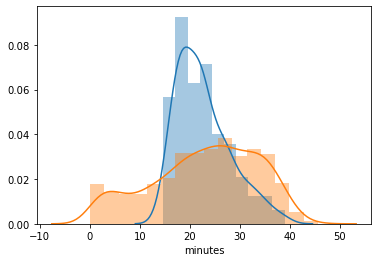

In [52]:
late_jan_box_scores["minutes"] = late_jan_box_scores["seconds_played"] / 60
# sns.distplot(jan_24_pred_actual.minutes)
sns.distplot(july_31_predictions.minutes)
sns.distplot(late_jan_box_scores.minutes)
# sns.distplot(feb_12_pred_actual.minutes)
#sns.jointplot(data = feb_12_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
#sns.jointplot(data = jan_24_pred_actual, x = 'predicted_points', y = 'actual_points', kind = 'reg')
# sns.distplot(feb_12_pred_actual.actual_points)
# sns.distplot(feb_12_pred_actual.predicted_points)

In [30]:
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SAC':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
dkp = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dkp = dkp[pd.isna(dkp.position)==False]
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')

ranks = []
seen = {}
player_names = [seen.setdefault(x, x) for x in dkp['name'] if x not in seen]
abbrv = [str(dkp.loc[dkp['name']==x, 'team'].iloc[0]).upper() for x in player_names]
player_positions = [dkp.loc[dkp['name']==x, 'position'].iloc[0] for x in player_names]
team_names = [all_abbrv.get(x) for x in abbrv]

for i in range(0, len(player_names)):
    if len(player_positions[i])<=2:
        ranks.append(dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i])].iloc[0])
    else:
        first_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][:2])].iloc[0]
        second_subrank =  dbp.loc[dbp['Team']==team_names[i], 'vs {0}'.format(player_positions[i][3:])].iloc[0]
        ranks.append((first_subrank + second_subrank)/2)

outputDefense = pd.DataFrame({'name':player_names, 'pos':player_positions, 'team':team_names, 'rank':ranks})
outputDefense.to_csv('./OutputCSVs/player_def_vs_position.csv', header=True, index=False)

In [5]:
import unicodedata

def strip_accents(text):
    text = unicodedata.normalize('NFD', text) .encode('ascii', 'ignore').decode("utf-8")
    return str(text)

team_def_vs_pos = []
opp_def_vs_pos = []
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SACRAMENTO KINGS':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
main_df = pd.read_csv('./AllCSVs/predictions_for_07_31_2020_unplayed.csv')
dk_positions = pd.read_csv('./OutputCSVs/draftkings_points.csv')
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')
dk_positions.dropna(subset=['position'],inplace=True)
player_positions = pd.Series(dk_positions.position.values,index=dk_positions.name).to_dict()
for i in range(len(main_df)):
    name = strip_accents(main_df['name'][i])
    position = player_positions.get(name)
    team = all_abbrv.get(main_df['team'][i])
    opponent = all_abbrv.get(main_df['opponent'][i])
    if position is None:
        team_def_vs_pos.append('NA')
        opp_def_vs_pos.append('NA')
    else:
        if len(position)<=2:
            team_def_vs_pos.append(dbp.loc[dbp['Team']==team, 'vs {0}'.format(position)].iloc[0])
            opp_def_vs_pos.append(dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position)].iloc[0])
        else:
            first_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position[:2])].iloc[0]
            second_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position[3:])].iloc[0]
            first_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position[:2])].iloc[0]
            second_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position[3:])].iloc[0]
            team_def_vs_pos.append((first_team_subrank + second_team_subrank)/2)
            opp_def_vs_pos.append((first_opp_subrank + second_opp_subrank)/2)
main_df['team def vs pos'] = team_def_vs_pos
main_df['opponent def vs pos'] = opp_def_vs_pos
main_df.to_csv('AllCSVs/predictions_for_07_31_2020_unplayed.csv')

TypeError: normalize() argument 2 must be str, not float